In [1]:
#import packages to do EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
%matplotlib inline

plt.style.use('fivethirtyeight')

import gc

# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
import matplotlib.font_manager


from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.sparse import coo_matrix,hstack,vstack

import pickle


#DecisionTree with hyper paramenter tuning.
#reference:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,roc_curve, auc
from sklearn.metrics import log_loss

from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import SGDClassifier
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)

#### Read vector from pickle file

In [2]:
with open('./data/train_vector.pkl', 'rb') as f:
    X = pickle.load(f)

In [3]:
with open('./data/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

In [4]:
print(X.shape[1],len(feature_names))

1037 1037


In [5]:
with open('./data/yvalues.pkl', 'rb') as f:
    y = pickle.load(f)

#### testing purpose only
traindata=10000
X = X.toarray()[:traindata,:]
y = y[:traindata]

In [6]:
print(X.shape,y.shape)

(307511, 1037) (307511,)


#### Model Evaluation

#### Hyper parameter tuning for Linear models

In [7]:
#split data only train and test. 
#Hypertuning with gridsearch and random 
#hypertuning, will do automatic cv. Hence, split data into Train and Test only. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=42)

In [8]:
gc.enable()
del X,y
gc.collect()

4

In [9]:
#LogisticRegression and SGDClassifier linear models to train nonzero features
def optimize_lr(x,y):    
    parameters_svm = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10],
                      'max_iter' : [100, 1000,1500,2000],
                      'penalty': ['l1', 'l2']
                     }
    clf=SGDClassifier(class_weight='balanced',learning_rate='optimal', eta0=0.0,
                      loss='log', random_state=42,n_jobs=-1)
    model = GridSearchCV(clf, parameters_svm,scoring='roc_auc', 
                       verbose=0,cv=5, return_train_score=True)
    model.fit(X=x,y=y)
    results = pd.DataFrame.from_dict(model.cv_results_)
    return results, model
results_lr,model_lr = optimize_lr(x=X_train,y=y_train)

In [9]:
#function to plot heatmap
def plot_heatmap(results):
    plt.close()
    results = results.sort_values(['param_alpha'],ascending =False) # descending
    results = results[['param_alpha','param_max_iter','param_penalty','mean_test_score', 'mean_train_score']]
    #get only n estimators and max depth only 
    max_scores = results.groupby(['param_alpha','param_max_iter']).max()
    max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
    plt.figure(figsize=(15, 10))
    ax_tr = plt.subplot(221)
    plt.title("Heatmap on Train data")
    sns.heatmap(max_scores['mean_train_score'], ax=ax_tr, fmt='.2f',cmap='YlGnBu',annot=True)
    ax_tr.set_xlabel('max_iter')
    ax_tr.set_ylabel('alpha')

    ax_cv = plt.subplot(222)
    plt.title("Heatmap on CV data")
    sns.heatmap(max_scores['mean_test_score'], ax=ax_cv, fmt='.2f',cmap='YlGnBu',annot=True)
    ax_cv.set_xlabel('max_iter')
    ax_cv.set_ylabel('alpha')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)    
    plt.show();
    return

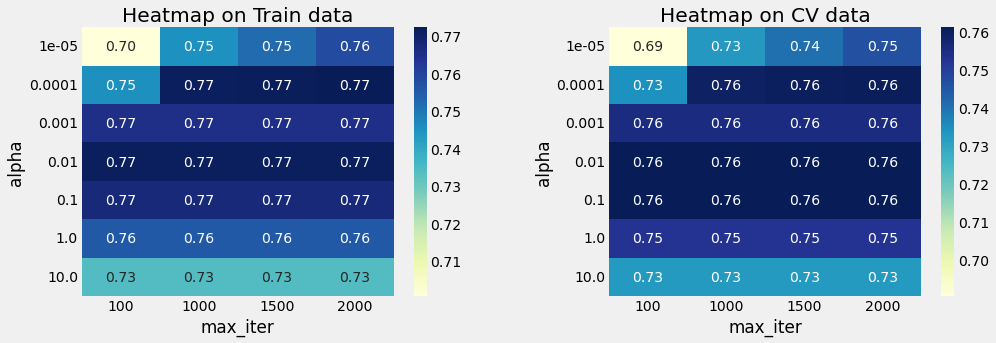

In [11]:
plot_heatmap(results_lr)

In [33]:
#https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
def plot_confusionmatrix(y_tr,y_trpred,y_te,y_tepred):
    from sklearn.metrics import confusion_matrix
    
    tn, fp, fn, tp = confusion_matrix(y_tr, np.round(y_trpred)).ravel()    
    #print('Training data tn-> {}, fp-> {}, fn-> {}, tp-> {}'.format(tn, fp, fn, tp), end=" ")
    #confusion matrix on training data 
    plt.figure(figsize=(10, 10))
    ax_tr = plt.subplot(221)
    cm_tr = confusion_matrix(y_tr, np.round(y_trpred))
    plt.title("Training data - Confusion Matrix")
    sns.heatmap(cm_tr, ax=ax_tr, fmt='d',cmap='YlGnBu',annot=True)
    # labels, title and ticks
    ax_tr.set_xlabel('Predicted labels');
    ax_tr.set_ylabel('True labels'); 
    ax_tr.set_ylim(2.0, 0)
    ax_tr.xaxis.set_ticklabels(['No','Yes']); 
    ax_tr.yaxis.set_ticklabels(['No','Yes']);
    
    #Confusion matrix on test data
    tn, fp, fn, tp = confusion_matrix(y_te, np.round(y_tepred)).ravel()    
    #print('Testing data tn-> {}, fp-> {}, fn-> {}, tp-> {}'.format(tn, fp, fn, tp), end=" ")
    
    ax_te = plt.subplot(222)
    cm_te = confusion_matrix(y_te, np.round(y_tepred))
    plt.title("Test data - Confusion Matrix")
    sns.heatmap(cm_te, ax=ax_te, fmt='d',cmap='YlGnBu',annot=True)
    # labels, title and ticks
    ax_te.set_xlabel('Predicted labels');
    ax_te.set_ylabel('True labels'); 
    ax_te.set_ylim(2.0, 0)
    ax_te.xaxis.set_ticklabels(['No','Yes']); 
    ax_te.yaxis.set_ticklabels(['No','Yes']);

    plt.show()
    return

In [11]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    return y_data_pred

In [12]:
def draw_roccurve(y_tr,y_tr_pred,y_te,y_te_pred):
    #fpr,tpr,thresholds 
    fpr, tpr, thresholds = roc_curve(y_tr, np.array(y_tr_pred))
    #auc score train score
    auc_train = round(auc(fpr, tpr),5)
    plt.plot(fpr, tpr, label=" AUC train ="+str(auc_train))
    plt.plot([0, 1], [0, 1],'r--')
    
    fpr, tpr, thresholds = roc_curve(y_te, np.array(y_te_pred))
    #auc score test score
    auc_test = round(auc(fpr, tpr),5)
    plt.plot(fpr, tpr, label=" AUC test ="+str(auc_test))
    plt.plot([0, 1], [0, 1],'b--')
    
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC" )
    plt.grid()
    plt.show()
    return auc_train,auc_test

In [15]:
model_lr.best_estimator_

SGDClassifier(alpha=0.01, class_weight='balanced', loss='log', max_iter=100,
              n_jobs=-1, random_state=42)

In [21]:
from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)
#class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced', np.unique(y_train),y_train))) 
#y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0,1], y=y_train)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.5439099467262235, 1: 6.193470811038297}

In [37]:
#based on the best parameters, predict values and plot AUC  and return the model
def measure_accuracy(X_tr,X_te,y_tr,y_te):
    clf=SGDClassifier(class_weight=d_class_weights,learning_rate='optimal', eta0=0.0,
                      loss='log', random_state=42,n_jobs=-1,verbose=0,
                     alpha=0.01,max_iter=400)
    
    #clf.set_params(**best_model.best_params_)
    
    clf.fit(X_tr, y_train)

    y_tr_pred = batch_predict(clf, X_tr)    
    y_te_pred = batch_predict(clf, X_te)

    plot_confusionmatrix(y_tr,y_tr_pred,y_te,y_te_pred)
    print('='*70)
    auc_train,auc_test=draw_roccurve(y_tr,y_tr_pred,y_te,y_te_pred)
    print('='*70)
    return clf, auc_train,auc_test,y_tr_pred,

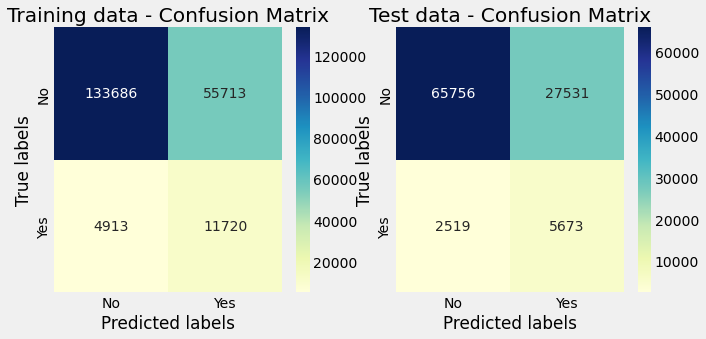

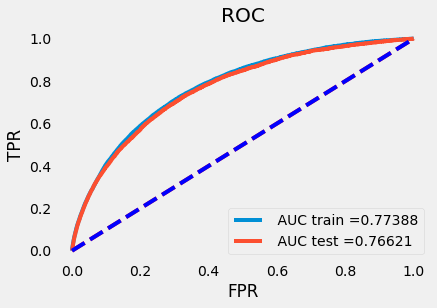

In [38]:
#measure accuracy with tfidf vector and model hypertuned with RandomSearch
#lr_model,auc_tr_lr_model,auc_te_lr_model = measure_accuracy(model_lr,X_train,X_test,y_train,y_test)
lr_model,auc_tr_lr_model,auc_te_lr_model,y_tr_pred,y_te_pred = measure_accuracy(X_train,X_test,y_train,y_test)

In [40]:
y_tr_pred_classes =np.round(y_tr_pred).reshape(-1,1).astype(int)
y_te_pred_classes = np.round(y_te_pred).reshape(-1,1).astype(int)

target_names=np.unique(y_tr_pred_classes).astype(int).astype(str)

from sklearn.metrics import classification_report
print("Train Results")
print("*"*55)
print(classification_report(y_train,y_tr_pred_classes, target_names= target_names))
print("*"*55)
print("Test Results")
print("*"*55)
print(classification_report(y_test,y_te_pred_classes, target_names=target_names))

Train Results
*******************************************************
              precision    recall  f1-score   support

           0       0.96      0.71      0.82    189399
           1       0.17      0.70      0.28     16633

    accuracy                           0.71    206032
   macro avg       0.57      0.71      0.55    206032
weighted avg       0.90      0.71      0.77    206032

*******************************************************
Test Results
*******************************************************
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     93287
           1       0.17      0.69      0.27      8192

    accuracy                           0.70    101479
   macro avg       0.57      0.70      0.54    101479
weighted avg       0.90      0.70      0.77    101479



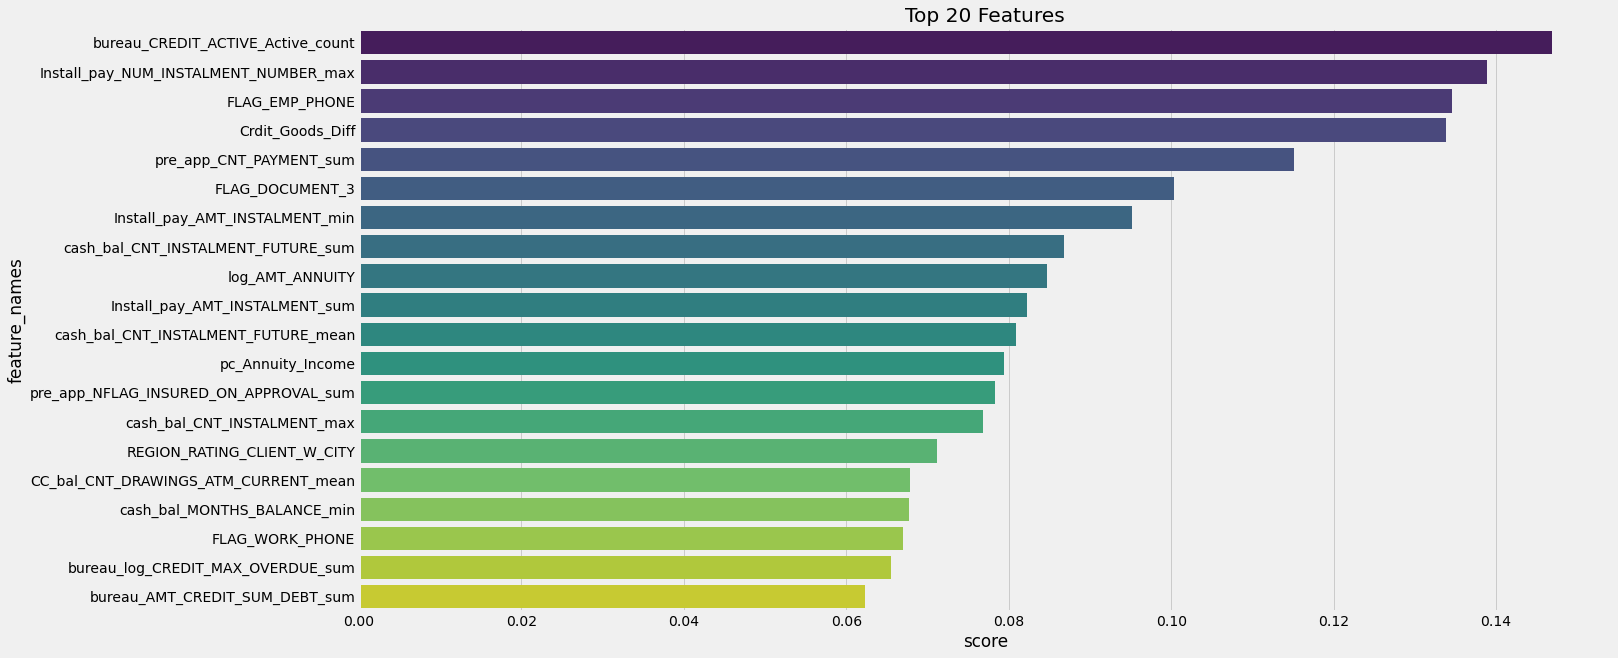

In [41]:
coeff=np.array(lr_model.coef_[0])
feature_names=np.array(feature_names)

df = pd.DataFrame({'feature_names':feature_names, 'score':coeff},index=None)
df.sort_values(by='score',ascending=False, inplace=True)
df_top20=df[:20]

#Plot bar plot for top 15 features
plt.close()
plt.figure(figsize =(20, 10))
# creating the bar plot
sns.barplot(y='feature_names', x='score', data=df_top20, palette="viridis")

plt.xticks(rotation=0)
plt.title('Top 20 Features')
plt.show()


In [42]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Feature","Score"]
for i in df_top20.index:
    x.add_row([df_top20['feature_names'][i],np.round(df_top20['score'][i],4)])
x.sortby = "Score"
x.reversesort = True
x.align["Feature"] = "l"
x.align["Score"] = "r"

print(x)

+---------------------------------------+--------+
| Feature                               |  Score |
+---------------------------------------+--------+
| bureau_CREDIT_ACTIVE_Active_count     | 0.1469 |
| Install_pay_NUM_INSTALMENT_NUMBER_max | 0.1388 |
| FLAG_EMP_PHONE                        | 0.1346 |
| Crdit_Goods_Diff                      | 0.1338 |
| pre_app_CNT_PAYMENT_sum               | 0.1152 |
| FLAG_DOCUMENT_3                       | 0.1004 |
| Install_pay_AMT_INSTALMENT_min        | 0.0951 |
| cash_bal_CNT_INSTALMENT_FUTURE_sum    | 0.0868 |
| log_AMT_ANNUITY                       | 0.0847 |
| Install_pay_AMT_INSTALMENT_sum        | 0.0823 |
| cash_bal_CNT_INSTALMENT_FUTURE_mean   | 0.0808 |
| pc_Annuity_Income                     | 0.0794 |
| pre_app_NFLAG_INSURED_ON_APPROVAL_sum | 0.0783 |
| cash_bal_CNT_INSTALMENT_max           | 0.0769 |
| REGION_RATING_CLIENT_W_CITY           | 0.0712 |
| CC_bal_CNT_DRAWINGS_ATM_CURRENT_mean  | 0.0678 |
| cash_bal_MONTHS_BALANCE_min  

In [16]:
import joblib
# save model
joblib.dump(lr_model, './results/model_LR.pkl')

['./results/model_LR.pkl']